# Handwritten Number Recognition with TFLearn and MNIST

In this notebook, we'll be building a neural network that recognizes handwritten numbers 0-9. 

This kind of neural network is used in a variety of real-world applications including: recognizing phone numbers and sorting postal mail by address. To build the network, we'll be using the **MNIST** data set, which consists of images of handwritten numbers and their correct labels 0-9.

We'll be using [TFLearn](http://tflearn.org/), a high-level library built on top of TensorFlow to build the neural network. We'll start off by importing all the modules we'll need, then load the data, and finally build the network.

In [1]:
# Import Numpy, TensorFlow, TFLearn, and MNIST data
import numpy as np
import tensorflow as tf
import tflearn
import tflearn.datasets.mnist as mnist

## Retrieving training and test data

The MNIST data set already contains both training and test data. There are 55,000 data points of training data, and 10,000 points of test data.

Each MNIST data point has:
1. an image of a handwritten digit and 
2. a corresponding label (a number 0-9 that identifies the image)

We'll call the images, which will be the input to our neural network, **X** and their corresponding labels **Y**.

We're going to want our labels as *one-hot vectors*, which are vectors that holds mostly 0's and one 1. It's easiest to see this in a example. As a one-hot vector, the number 0 is represented as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], and 4 is represented as [0, 0, 0, 0, 1, 0, 0, 0, 0, 0].

### Flattened data

For this example, we'll be using *flattened* data or a representation of MNIST images in one dimension rather than two. So, each handwritten number image, which is 28x28 pixels, will be represented as a one dimensional array of 784 pixel values. 

Flattening the data throws away information about the 2D structure of the image, but it simplifies our data so that all of the training data can be contained in one array whose shape is [55000, 784]; the first dimension is the number of training images and the second dimension is the number of pixels in each image. This is the kind of data that is easy to analyze using a simple neural network.

In [2]:
# Retrieve the training and test data
trainX, trainY, testX, testY = mnist.load_data(one_hot=True)

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


## Visualize the training data

Provided below is a function that will help you visualize the MNIST data. By passing in the index of a training example, the function `show_digit` will display that training image along with its corresponding label in the title.

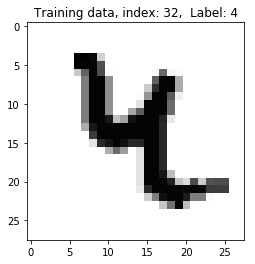

In [43]:
# Visualizing the data
import matplotlib.pyplot as plt
%matplotlib inline

# Function for displaying a training image by it's index in the MNIST set
def show_digit(index):
    label = trainY[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = trainX[index].reshape([28,28])
    plt.title('Training data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()
    
# Display the first (index 0) training image
show_digit(32)

## Building the network

TFLearn lets you build the network by defining the layers in that network. 

For this example, you'll define:

1. The input layer, which tells the network the number of inputs it should expect for each piece of MNIST data. 
2. Hidden layers, which recognize patterns in data and connect the input to the output layer, and
3. The output layer, which defines how the network learns and outputs a label for a given image.

Let's start with the input layer; to define the input layer, you'll define the type of data that the network expects. For example,

```
net = tflearn.input_data([None, 100])
```

would create a network with 100 inputs. The number of inputs to your network needs to match the size of your data. For this example, we're using 784 element long vectors to encode our input data, so we need **784 input units**.


### Adding layers

To add new hidden layers, you use 

```
net = tflearn.fully_connected(net, n_units, activation='ReLU')
```

This adds a fully connected layer where every unit (or node) in the previous layer is connected to every unit in this layer. The first argument `net` is the network you created in the `tflearn.input_data` call, it designates the input to the hidden layer. You can set the number of units in the layer with `n_units`, and set the activation function with the `activation` keyword. You can keep adding layers to your network by repeated calling `tflearn.fully_connected(net, n_units)`. 

Then, to set how you train the network, use:

```
net = tflearn.regression(net, optimizer='sgd', learning_rate=0.1, loss='categorical_crossentropy')
```

Again, this is passing in the network you've been building. The keywords: 

* `optimizer` sets the training method, here stochastic gradient descent
* `learning_rate` is the learning rate
* `loss` determines how the network error is calculated. In this example, with categorical cross-entropy.

Finally, you put all this together to create the model with `tflearn.DNN(net)`.

**Exercise:** Below in the `build_model()` function, you'll put together the network using TFLearn. You get to choose how many layers to use, how many hidden units, etc.

**Hint:** The final output layer must have 10 output nodes (one for each digit 0-9). It's also recommended to use a `softmax` activation layer as your final output layer. 

In [29]:
# Define the neural network
def build_model(hidden_layers, learning_rate):
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    #### Your code ####
    # Include the input layer, hidden layer(s), and set how you want to train the model
    net = tflearn.input_data([None, 784])
    for n_units in hidden_layers:
        net = tflearn.fully_connected(net, n_units, activation='ReLU')
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net,  optimizer='sgd', learning_rate=learning_rate,
                             loss='categorical_crossentropy')
    
    # This model assumes that your network is named "net"    
    model = tflearn.DNN(net)
    return model

In [30]:
np.log10(784)

2.8943160626844384

In [31]:
layers = list(reversed(list(map(int,np.round(np.logspace(1,2.89,5))[1:-1]))))
layers

[262, 88, 30]

In [32]:
# Build the model
model = build_model([262, 88, 30],0.1)

## Training the network

Now that we've constructed the network, saved as the variable `model`, we can fit it to the data. Here we use the `model.fit` method. You pass in the training features `trainX` and the training targets `trainY`. Below I set `validation_set=0.1` which reserves 10% of the data set as the validation set. You can also set the batch size and number of epochs with the `batch_size` and `n_epoch` keywords, respectively. 

Too few epochs don't effectively train your network, and too many take a long time to execute. Choose wisely!

In [33]:
# Training
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=100, n_epoch=20)

Training Step: 9899  | total loss: 0.54191 | time: 2.126s
| SGD | epoch: 020 | loss: 0.54191 - acc: 0.9667 -- iter: 49400/49500
Training Step: 9900  | total loss: 0.48993 | time: 3.141s
| SGD | epoch: 020 | loss: 0.48993 - acc: 0.9701 | val_loss: 0.09387 - val_acc: 0.9776 -- iter: 49500/49500
--


In [37]:
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=100, n_epoch=10)

Training Step: 19799  | total loss: 0.20712 | time: 1.978s
| SGD | epoch: 040 | loss: 0.20712 - acc: 0.9878 -- iter: 49400/49500
Training Step: 19800  | total loss: 0.18737 | time: 2.991s
| SGD | epoch: 040 | loss: 0.18737 - acc: 0.9890 | val_loss: 0.01032 - val_acc: 0.9967 -- iter: 49500/49500
--


## Testing
After you're satisified with the training output and accuracy, you can then run the network on the **test data set** to measure it's performance! Remember, only do this after you've done the training and are satisfied with the results.

A good result will be **higher than 95% accuracy**. Some simple models have been known to get up to 99.7% accuracy!

In [38]:
# Compare the labels that our model predicts with the actual labels

# Find the indices of the most confident prediction for each item. That tells us the predicted digit for that sample.
predictions = np.array(model.predict(testX)).argmax(axis=1)

# Calculate the accuracy, which is the percentage of times the predicated labels matched the actual labels
actual = testY.argmax(axis=1)
test_accuracy = np.mean(predictions == actual, axis=0)

# Print out the result
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9749
